In [636]:
import numpy as np
import os
import gzip
import random
import time
import signal

import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'hot'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [618]:
data = ""
ddir = "../data/books/witcher_rus/"
for fn in sorted(os.listdir(ddir)):
    if fn.endswith(".gz"):
        with gzip.open(ddir + fn, "rb") as f:
            data += f.read().decode("utf-8").replace("\r", "")
charset = sorted(set(data))
print(charset)
print("%s chars, %s unique" % (len(data), len(charset)))
chidx = {ch: i for i, ch in enumerate(charset)}
chvec = {ch: np.array([chidx[ch] == i for i in range(len(charset))], dtype=np.float32) for ch in charset}

['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']
5088376 chars, 140 unique


In [619]:
def tanh_deriv(x):
        return 1/np.cosh(x)**2

def softmax(y):
    y = y - np.max(y)
    ey = np.exp(y)
    return ey/np.sum(ey)

def cross_entropy_loss(y, ai):
    return -np.log(y[ai])

In [620]:
class Cell:
    def __init__(self, sx, sh, sy, mag=1e-1):
        self.sizes = (sx, sh, sy)
        layer_sizes = [(sx, sh), (sh, sh), (sh, sy)] # W_xh, W_hh, W_hy
        self.params = [ mag*np.random.randn(*s) for s in layer_sizes]
    
    def step(self, h, x, mem=False):
        W_xh, W_hh, W_hy = self.params
        v = np.dot(x, W_xh) + np.dot(h, W_hh)
        a = np.tanh(v)
        y = np.dot(a, W_hy)
        if mem:
            m = [x, h, v, a, y]
        else:
            m = None
        return a, softmax(y), m
    
    def newgrad(self):
        return [np.zeros_like(v) for v in self.params]
    
    def newstate(self):
        return np.zeros(self.sizes[1], dtype=np.float64)
    
    def backprop(self, grad, eh, m, ey):
        W_xh, W_hh, W_hy = self.params
        dW_xh, dW_hh, dW_hy = grad
        x, h, v, a, y = m
        
        dW_hy += np.outer(a, ey)
        ea = np.dot(W_hy, ey) + eh
        ev = ea*tanh_deriv(v)
        dW_xh += np.outer(x, ev)
        dW_hh += np.outer(h, ev)
        eh = np.dot(W_hh, ev)
        
        return eh
    
    def learn(self, grad, learning_rate, adagrad=None, rmsprop=0):
        if adagrad is None:
            for W, dW in zip(self.params, grad):
                W -= learning_rate*dW
        else:
            for W, dW, aW in zip(self.params, grad, adagrad):
                if rmsprop == 0:
                    aW += dW**2
                else:
                    aW = rmsprop*aW + (1 - rmsprop)*dW**2
                W -= learning_rate*dW/np.sqrt(aW + 1e-8)

In [646]:
plots = {
    "sgd": [],
    "adagrad": [],
    "rmsprop": [],
}

In [656]:
net = Cell(len(charset), 50, len(charset))
grad = net.newgrad()

In [657]:
seqlen = 100
rate = 1e-1

loss = 0.0
mem = []
iepoch = 0
pos = 0
h = net.newstate()
adagrad = net.newstate()
rmsprop = 1e-3

mode = "rmsprop"
learn_keys = {}
if mode == "adagrad" and mode == "rmsprop":
    learn_keys["adagrad"] = adagrad
    if mode == "rmsprop":
        learn_keys["rmsprop"] = rmsprop

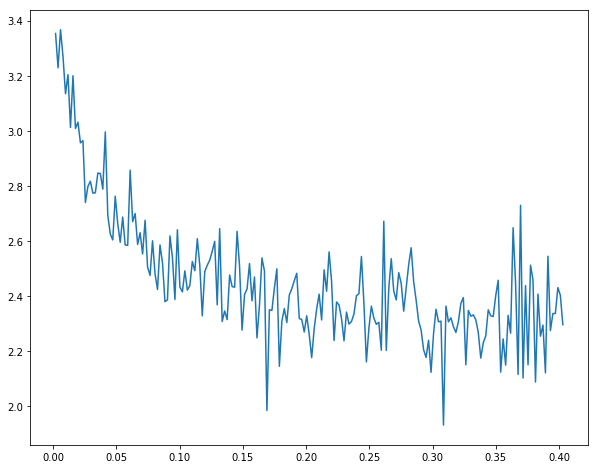

0 - 2050000/5088376: 2.29571571630623
о расмаловно в о ене тавадось засеройтя!..

- ПИи прелцыванныфо есла с Тубы даможила вни?

Подлатась
done


In [658]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

while not done:
    h, y, m = net.step(h, chvec[data[pos]], mem=True)
    mem.append((m, y, data[pos + 1]))
    loss = 0.99*loss + 0.01*cross_entropy_loss(y, chidx[data[pos + 1]])
    
    if (pos + 1) % seqlen == 0:
        [dW.fill(0) for dW in grad]
        eh = net.newstate()
        for m, y, ch in reversed(mem):
            eh = net.backprop(grad, eh, m, y - chvec[ch])
        [np.clip(dW, -5, 5, out=dW) for dW in grad] # mitigate exploding gradient
        net.learn(grad, rate/seqlen, **learn_keys)
        mem = []
    
    if pos % 10000 == 0:
        clear_output(wait=True)
        plots[mode].append((iepoch + pos/len(data), loss))
        out = ""
        ch = data[pos]
        _h = h
        for i in range(100):
            _h, y, _ = net.step(_h, chvec[ch])
            ch = np.random.choice(charset, p=y)
            out += ch
        plt.plot(*zip(*plots[mode][1:]))
        plt.show()
        print("%s - %s/%s: %s" % (iepoch, pos, len(data), loss))
        print(out)
        
    pos += 1
    if pos >= len(data) - 1:
        pos = 0
        iepoch += 1
        
print("done")

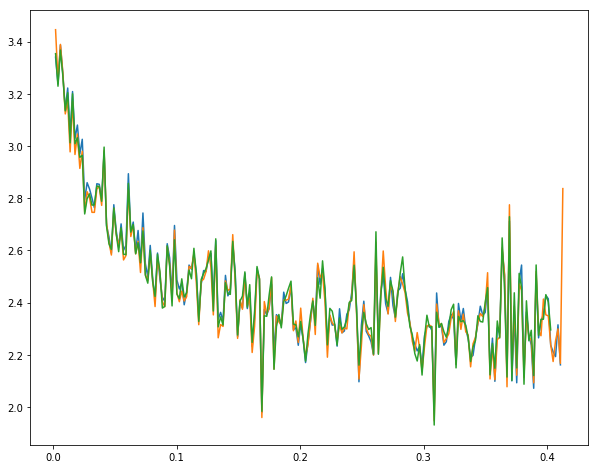

In [659]:
pltargs = []
for k, v in plots.items():
    pltargs.extend(zip(*v[1:]))
plt.plot(*pltargs)
plt.show()